<a href="https://colab.research.google.com/github/jorgejgleandro/bjj-log-app-qsi-api/blob/dev/MachineLearning/notebooks/BJJ_Heart_JLeandro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP: BJJ Training Log App - Heart Attack Classification
## [Heart Disease - Dataset - UCI ML Repository](https://archive.ics.uci.edu/dataset/45/heart+disease)
- Cleveland,
- Hungary,
- Switzerland
- VA Long Beach

### PUC-RIO - Pós-Graduação em Engenharia de Software

### Disciplina: Qualidade de Software, Segurança e Sistemas Inteligentes 40530010063_20240_01

####Aluno: Jorge de Jesus Gomes Leandro
14 de Setembro de 2024
__[jorgejgleandro@gmail.com ](mailto:jorgejgleandro@gmail.com)__ - __[br.linkedin.com/in/jorgejgleandro/](https://www.linkedin.com/in/jorgejgleandro/)__


In [1]:
#matplotlib inline
import warnings

# Ignore warnings
warnings.simplefilter("ignore")

import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

import os
import io
import time

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display, HTML

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import balanced_accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin

from google.colab import files

# Objetivo

O objetivo do uso de um o modelo de Aprendizagem de Máquina neste sistema é o de permitir que a administração de uma escola de BJJ faça uma previsáo preliminar, dado um conjunto de resultados de exames médicos, sobre o risco de ataque cardíaco durante uma sessão de treinamento dos praticantes de sua escola. Em caso de alto risco, o aluno seria encaminhado para um especialista, podendo ou não retornar aos treinos, a critério do médico.

## 1. Funções úteis
> Destacar valores max ou min em uma tabela exibindo os resultados

In [2]:
def highlight_min(s):
    # highlight the minimum in a Series yellow.
    is_min = s == s.min()
    return ['color: red; background-color: yellow; font-weight: bold' if v else '' for v in is_min]

In [3]:
def highlight_max(s):
    # highlight the maximum in a Series yellow.
    is_max = s == s.max()
    return ['color: red; background-color: yellow; font-weight: bold' if v else '' for v in is_max]

## 2. Diretórios de saída

> Os pipelines contendo *scalers* e *models*, bem como *dados* serão serializados e armazenados nesses diretórios

In [4]:
if not os.path.exists("./heart/models/"):
  os.makedirs("./heart/models/")
if not os.path.exists("./heart/data/"):
  os.makedirs("./heart/data/")

## 3. Dataset (Base de dados)

### 3.1 Descrição

A base de dados [Heart Disease](https://archive.ics.uci.edu/dataset/45/heart+disease) compila dados de quatro outras bases de dados, a saber,Cleveland, Hungary, Switzerland, e a VA Long Beach, tendo sido disponibilizada na UCI Machine Learning Repository.

### 3.2 Características

Esta base de dados é composta por $13$ características para casos positivos e negativos de ataque cardíaco, o rótulo devidamente anotado na última coluna.

São elas, em Inglês, como consta na documentação original:

- age : age of the individual
- sex : sex of the individual
- cp : Chest Pain type chest pain type
-- 1: typical angina
-- 2: atypical angina
-- 3: non-anginal pain
-- 4: asymptomatic
-trtbps : resting blood pressure (in mm Hg)
- chol : cholestoral in mg/dl fetched via BMI sensor
- fbs : fasting blood sugar > 120 mg/dl
-- 1: true
-- 0: false
- restecg : resting electrocardiographic results
-- 0: normal
-- 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
--  2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- thalachh : maximum heart rate achieved
- exng: exercise induced angina
-- 1: yes
-- 0: no
- oldpeak : ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot)
- slp : the slope of the peak exercise ST segment
-- 1: upsloping
-- 2: flat
-- 3: downsloping
- caa : The number of major vessels (0-3) colored by flourosopy
- thall : A blood disorder called thalassemia
-- 3: normal
-- 6: fixed defect
-- 7: reversable defect
- output
-- 0: < 50% diameter narrowing - less chance of heart attack
-- 1: > 50% diameter narrowing - more chance of heart attack


### 3.2 Anonimização

Segundo a documentação do repositório, os nomes e números de seguro social dos pacientes foram removidos da base de dados e substituídos por valores de fantasia.

### 3.3 Carga de dados

O arquivo **heart.csv** encontra-se hospedado no repositório correspondente a este projeto no GitHub, aqui referenciado por URL em sua versão *raw*, dispensando qualquer configuração ou ajuste para seu acesso:


In [5]:
dataset_url = 'https://raw.githubusercontent.com/jorgejgleandro/bjj-log-app-qsi-api/dev/MachineLearning/data/heart.csv'
dataset_full_pd = pd.read_csv(dataset_url)

## 4. Separação de Dados em conjuntos de Treino e Teste (Holdout)

> Divisão da base de dados em conjuntos de treino e teste para treinamento e seleção de modelo, assim como para avaliação e relatório de desempenho, respectivamente.

In [6]:
train_pd, test_pd = train_test_split(dataset_full_pd, test_size=0.2, random_state=37)

## 5. Exploração dos dados

### 5.1 Visualização em tabela das primeiras linhas da base de dados

In [7]:
train_pd.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
218,65,1,0,135,254,0,0,127,0,2.8,1,1,3,0
155,58,0,0,130,197,0,1,131,0,0.6,1,0,2,1
121,59,1,0,138,271,0,0,182,0,0.0,2,0,2,1
211,61,1,0,120,260,0,1,140,1,3.6,1,1,3,0
102,63,0,1,140,195,0,1,179,0,0.0,2,2,2,1


> Note que a diferença de escalas de valores entre diferentes características demanda técnicas de padronização ou normalização na etapa de preparo dos dados.

### 5.2 Sumário do espaço de características - Conjunto para treino

In [8]:
train_pd.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000
mean,54.454545,0.669421,0.979339,132.194215,245.913223,0.161157,0.508264,149.458678,0.338843,0.982645,1.392562,0.677686,2.293388,0.541322
std,9.142033,0.471396,1.048407,16.925253,52.267711,0.368438,0.525229,22.161430,0.474297,1.083883,0.589347,0.982966,0.618422,0.499322
min,34.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.250000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,132.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,0.000000,152.500000,0.000000,0.600000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,273.000000,0.000000,1.000000,165.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,192.000000,1.000000,5.600000,2.000000,4.000000,3.000000,1.000000


> Observe que a contagem de vetores de características indica que não há dados faltantes ou inválidos.

### 5.3 Verificação sobre características com valores inválidos (NAN)

In [9]:
print('NaNs: ', len(dataset_full_pd[dataset_full_pd.isna().any(axis=1)]))

NaNs:  0


### 5.4 Visualização das distribuições das características

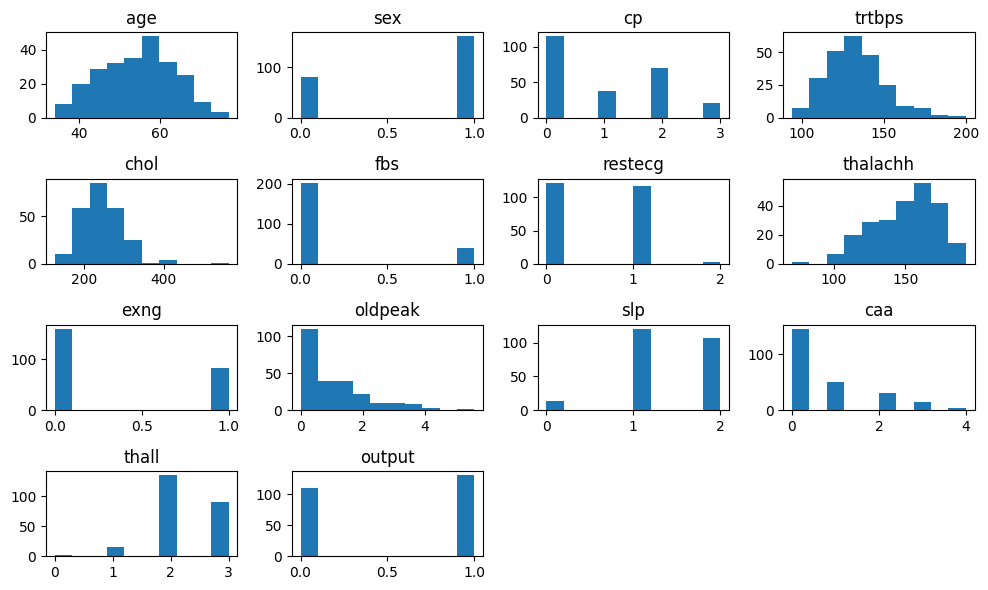

In [10]:
fig, axs = plt.subplots(4, 4, figsize=(10, 6), layout='constrained', squeeze=True)
for ax, feat in zip(axs.flat, train_pd.columns):
    ax.set_title(f'{feat}')
    ax.hist(train_pd[feat])
fig.delaxes(axs[3, 2])
fig.delaxes(axs[3, 3])
plt.tight_layout()
plt.show()

> Conforme visto pelo gráfico de rótulo de saída (classes), esta base de dados está ligeiramente desbalanceada. Por esta razão, a métrica denomimada **acurária normalizada** [balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score) foi escolhida como métrica de avaliação.

## 6. Data Frames

> Separando características de rótulos em dois dataframes no conjunto de treinamento.

In [11]:

X_train_pd = train_pd.drop("output", axis=1)
Y_train_pd = train_pd["output"].copy()

> Separando características de rótulos em dois dataframes no conjunto de teste.

In [12]:
X_test_pd = test_pd.drop("output", axis=1)
Y_test_pd = test_pd["output"].copy()

> Definindo uma semente para fins de reprodutibilidade

In [13]:
seed = 7

## 7. Hiperparâmetros para seleção de modelos por **Grid Search**

> Além dos modelos solicitados nos requisitos, ou seja, *KNN, Árvore de Classificação (CART), Naive Bayes (NB) e SVM*, foi incluída a Regressão Logística (LR) no processo de treinamento seleção de modelos.

In [14]:
param_grids = {
    'LR': {
        'LR__C': [0.01, 0.1, 1, 10, 100],
        'LR__solver': ['liblinear', 'saga']
    },
    'KNN': {
        'KNN__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
        'KNN__metric': ["euclidean", "manhattan", "minkowski"]
    },
    'CART': {
        'CART__max_depth': [None, 10, 20, 30, 40, 50],
        'CART__min_samples_split': [2, 5, 10],
        'CART__min_samples_leaf': [1, 2, 4]
    },
    'NB': {
        'NB__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    'SVM': {
        'SVM__C': [0.1, 1, 10, 100],
        'SVM__gamma': [1, 0.1, 0.01, 0.001],
        'SVM__kernel': ['rbf', 'linear']
    }
}

## 8. Modelos

> A lista de modelos treinados e testados

In [15]:
models = []
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

## 9. Pipelines

> Como apontado em aula, a fim de garantir que a mesma estratégia de normalização ou padronização para um certo modelo aplicada durante o treinamento e validação seja aplicada ao conjunto de teste e colocada em produção, adotamos o uso de **Pipelines**, que encapsulam um *scaler* e um *model* no mesmo objeto.

In [16]:
# Pipelines components
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Pipelines list
pipelines = []

# Setting a pipeline for each model
for name, model in models:
    pipelines.append((name + '-orig', Pipeline(steps=[(name, model)])))
    pipelines.append((name + '-padr', Pipeline(steps=[standard_scaler, (name, model)])))
    pipelines.append((name + '-norm', Pipeline(steps=[min_max_scaler, (name, model)])))

## 10. Treinamento em Validação-Cruzada com seleção de Hiperparâmetros mediante otimização por *Grid Search*

O treinamento foi realizado em Validação-Cruzada, tendo sido o  conjunto de treino dividido em 5 subconjuntos, dos quais 4 subconjuntos foram usados para treino e 1 subconjunto foi usado para validação.

A divisão em subconjuntos seguiu a estratégia *StratifiedKFold*, para minimizar a predominância da classe com maior número de amostras sobre os subconjuntos. Os dados foram embaralhados antes da divisão em subconjuntos.

O parâmetro *refit* definido como verdadeiro garante, segundo a documentação do *Scikit-Learn* que, ao final do processo iterativo de treinamento e validação, os modelos são retreinados com o conjunto de treino completo.

Os resultados do treinamento para cada *pipeline* são guardados em uma lista para posterior determinação e escolha do modelo vencedor e relatório.

Todos os modelos são serializados em arquivos *.pkl* e armazenados em disco.


In [17]:
grid_searches = []
scoring = ['balanced_accuracy']
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

for name, pipeline in pipelines:
    model_type = name.split('-')[0]
    if model_type in param_grids:
        param_grid = param_grids[model_type]
    else:
        param_grid = {}

    print('Training ', name, ' model ... - Params: ', param_grid)
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, scoring=scoring[0], refit=True, return_train_score=True, verbose=2)
    t0 = time.time()
    grid_search.fit(X_train_pd, Y_train_pd)
    train_time = time.time() - t0
    print(name + ' training time: %.3f s' % train_time)
    print('---------------------------------------')
    grid_searches.append((name, grid_search))

    # serialize Scikit-learn model to .pkl
    joblib.dump(grid_search.best_estimator_, './heart/models/' + name + '.pkl')



Training  LR-orig  model ... - Params:  {'LR__C': [0.01, 0.1, 1, 10, 100], 'LR__solver': ['liblinear', 'saga']}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...................LR__C=0.01, LR__solver=liblinear; total time=   0.0s
[CV] END ...................LR__C=0.01, LR__solver=liblinear; total time=   0.0s
[CV] END ...................LR__C=0.01, LR__solver=liblinear; total time=   0.0s
[CV] END ...................LR__C=0.01, LR__solver=liblinear; total time=   0.0s
[CV] END ...................LR__C=0.01, LR__solver=liblinear; total time=   0.0s
[CV] END ........................LR__C=0.01, LR__solver=saga; total time=   0.0s
[CV] END ........................LR__C=0.01, LR__solver=saga; total time=   0.0s
[CV] END ........................LR__C=0.01, LR__solver=saga; total time=   0.0s
[CV] END ........................LR__C=0.01, LR__solver=saga; total time=   0.1s
[CV] END ........................LR__C=0.01, LR__solver=saga; total time=   0.1s
[CV] END ........

## 11. Reportando erros durante Validação

O seguinte algoritmo convenientemente:
* imprime todos os resultados,
* formata os resultados do treinamento em um *dataframe* para posterior apresentação em tabela e
* determina o modelo vencedor, isto é, com melhor desempenho durante validação.

In [18]:
kk = 0
models_labels = []
all_test_splits_scores = []
dict_results = {}
results = []
names = []
dict_scores = {}
split_names = []
[split_names.append('split' + str(i) + '_test_score') for i in range(0, n_splits)]
max_score = -np.inf
best_model = ''
best_name = ''

for (name, grid_search) in grid_searches:
    result = grid_search.cv_results_
    results.append(result['mean_test_score'])
    names.append(name)
    splits_scores = []
    splits_scores = [result[split_name] for split_name in split_names]
    all_test_splits_scores.append(splits_scores)
    for test_mean, test_std, train_mean, train_std, config in zip(result["mean_test_score"], result["std_test_score"], result["mean_train_score"], result["std_train_score"], result["params"]):
        print('Model:%s - Config: %s - Mean test score: %.10e - STD test score: %.10e - Mean train score: %.10e - STD train score: %.10e' % (name, config, np.sqrt(test_mean), test_std, np.sqrt(train_mean), train_std))
        lname = name
        while(lname in dict_results):
            kk = kk + 1
            lname = name + '_' + str(kk)
        models_labels.append(lname)
        kk = 0
        aux = np.sqrt(test_mean)
        dict_results[lname] = pd.Series([aux, test_std, np.sqrt(train_mean), train_std, config], index=['test_mean', 'test_std', 'train_mean', 'train_std', 'params'])
        if aux > max_score:
            max_score = aux
            best_model = grid_search.best_estimator_
            best_name = name



Model:LR-orig - Config: {'LR__C': 0.01, 'LR__solver': 'liblinear'} - Mean test score: 8.6205430178e-01 - STD test score: 4.7294029968e-02 - Mean train score: 8.6840779274e-01 - STD train score: 5.6651925957e-03
Model:LR-orig - Config: {'LR__C': 0.01, 'LR__solver': 'saga'} - Mean test score: 8.1325737976e-01 - STD test score: 8.4755211858e-02 - Mean train score: 8.3586953873e-01 - STD train score: 2.3915465920e-02
Model:LR-orig - Config: {'LR__C': 0.1, 'LR__solver': 'liblinear'} - Mean test score: 9.0886383322e-01 - STD test score: 3.6649835459e-02 - Mean train score: 9.1955708835e-01 - STD train score: 1.3539190716e-02
Model:LR-orig - Config: {'LR__C': 0.1, 'LR__solver': 'saga'} - Mean test score: 8.1325737976e-01 - STD test score: 8.4755211858e-02 - Mean train score: 8.3586953873e-01 - STD train score: 2.3915465920e-02
Model:LR-orig - Config: {'LR__C': 1, 'LR__solver': 'liblinear'} - Mean test score: 9.1355900063e-01 - STD test score: 4.2258800311e-02 - Mean train score: 9.2621683638e

Se os hiperparâmetros foram arranjados em ordem crescente de complexidade e o algoritmo selecionou o primeiro *pipeline* com melhor desempenho até a iteração corrente, pelo critério da **Navalha de Occam**, pode-se dizer que o modelo escolhido como  vencedor é aquele que obteve o melhor desempenho segundo a métrica, mas também é o mais simples dentre outros com mesmo desempenho.

In [19]:
print(best_model)

Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('SVM', SVC(C=1, gamma=1, kernel='linear'))])


## 12. Tabela - Comparação entre Modelos testados sobre os Conjuntos de Validação, durante o treinamento

A tabela exibe o desempenho pela métrica *acurácia normalizada* média e desvio padrão, durante o treino e durante a validação. Os respectivos hiperparâmetros aparecem na última linha.

Os melhores vencedores (**_Best_ _models_**) são destacados em amarelo. Mova a barra para a direita para visualizá-los.

In [20]:
results_df = pd.DataFrame(dict_results)
results_df.style.apply(highlight_max, subset=pd.IndexSlice[['test_mean'], np.sort(models_labels)], axis=1)

## 13. Comparação Visual do desempenho de Modelos por **Boxplot**

A visualização dos dados confirma o desempenho do modelo vencedor indicado na tabela.

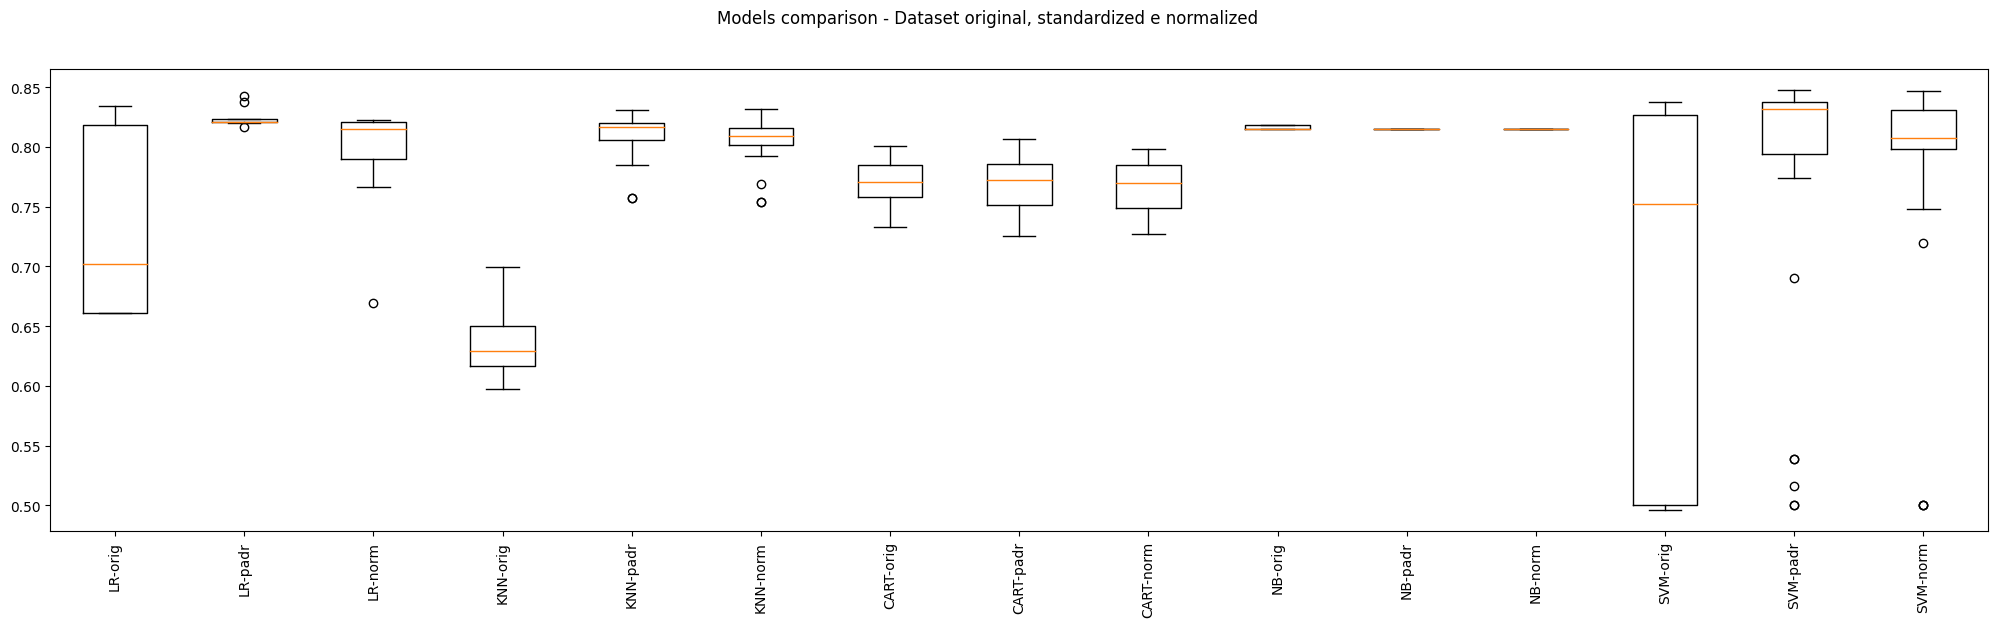

In [21]:
fig = plt.figure(figsize=(25,6))
fig.suptitle('Models comparison - Dataset original, standardized e normalized')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

## 14. Avaliação do Modelo sobre o Conjunto de Teste

Vale ressaltar que, como o parâmetro **refit** foi definido como *true* para a estratégia [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), os modelos foram automaticamente retreinados sobre todo o conjunto de treinamento, incluindo o modelo vencedor.

Como esperado, o desempenho do modelo vencedor caiu de um desempenho médio em validação de $0.920683$ para um desempenho de $0.841503$ em teste, depois de ter sido retreinado sobre todo o conjunto de treino.

Esta queda de desempenho sugere um prejuízo da capacidade de generalização do modelo, provavelmente relacionada ao tamanho da base de dados e a variabilidade de suas amostras.

In [22]:
predictions = best_model.predict(X_test_pd)
print(balanced_accuracy_score(Y_test_pd, predictions))

0.8415032679738561


## 15. Versão final do modelo

Vale salientar que, para produção, o modelo vencedor deveria ser retreinado com toda a base de dados.

No entanto, para o propósito deste trabalho de testar o modelo a partir de chamadas via requisições *REST* a uma *API* num servidor, o conjunto de Teste será mantido separado, ou seja, o modelo não será retreinado sobre a totalidade dos dados.

## 16. Simulação de predição do modelo vencedor sobre dados desconhecidos

In [23]:
unseen_data = {'age':  [35.0, 40.0, 72.0],
        'sex': [1.0, 1.0, 0.0],
        'cp': [1.0, 2.0, 3.0],
        'trtbps': [99.0, 120.0, 185.0],
        'chol': [130.0, 350.0, 210.0],
        'fbs': [0.0, 1.0, 0.0],
        'restecg': [2.0, 0.0, 1.0],
        'thalachh': [80.0, 125.0, 190.0],
        'exng': [1.0, 1.0, 0.0],
        'oldpeak': [4.3, 0.9, 2.5],
        'slp': [0.0, 2.0, 1.0],
        'caa': [3.0, 1.0, 2.0],
        'thall': [1.0, 2.0, 3.0],
        }

atributos = ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs','restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall']
unseen_data_pd = pd.DataFrame(unseen_data, columns=atributos)

unseen_array_input = unseen_data_pd.values
X_input = unseen_array_input[:,0:].astype(float)

outputs = best_model.predict(X_input)
print(outputs)

[0 1 0]


## 17. Serializando o *pipeline* vencedor: *model* e *scaler*

O *pipeline* vencedor (**_Winner_ _pipeline_**) abaixo, ou seja, a concatenação de *scaler* e *modelo*, é escolhido com base na **acurácia normalizada** média reportada para os conjuntos de teste durante a etapa de Validação-Cruzada (veja Tabela na seção 12).

In [24]:
best_model_filename = 'final_best_model_heart.pkl'
joblib.dump(best_model, best_model_filename)

['final_best_model_heart.pkl']

## 18. Salvando o conjunto de Teste separado para teste no ambiente da *web app*

In [25]:
X_test_df = pd.DataFrame(X_test_pd, columns=test_pd.columns[:-1])
Y_test_df = pd.DataFrame(Y_test_pd, columns=[test_pd.columns[-1]])
X_test_df.to_csv("./heart/data/X_test_dataset_heart.csv", index=False)
Y_test_df.to_csv("./heart/data/y_test_dataset_heart.csv", index=False)

In [26]:
!ls ./heart/models

CART-norm.pkl  KNN-norm.pkl  LR-norm.pkl  NB-norm.pkl  SVM-norm.pkl
CART-orig.pkl  KNN-orig.pkl  LR-orig.pkl  NB-orig.pkl  SVM-orig.pkl
CART-padr.pkl  KNN-padr.pkl  LR-padr.pkl  NB-padr.pkl  SVM-padr.pkl


In [27]:
!zip -r heart_models.zip ./heart/models

  adding: heart/models/ (stored 0%)
  adding: heart/models/CART-norm.pkl (deflated 64%)
  adding: heart/models/NB-norm.pkl (deflated 43%)
  adding: heart/models/KNN-orig.pkl (deflated 89%)
  adding: heart/models/KNN-padr.pkl (deflated 85%)
  adding: heart/models/LR-norm.pkl (deflated 48%)
  adding: heart/models/CART-orig.pkl (deflated 64%)
  adding: heart/models/SVM-orig.pkl (deflated 77%)
  adding: heart/models/NB-padr.pkl (deflated 28%)
  adding: heart/models/CART-padr.pkl (deflated 60%)
  adding: heart/models/LR-orig.pkl (deflated 36%)
  adding: heart/models/KNN-norm.pkl (deflated 87%)
  adding: heart/models/NB-orig.pkl (deflated 30%)
  adding: heart/models/SVM-norm.pkl (deflated 71%)
  adding: heart/models/LR-padr.pkl (deflated 33%)
  adding: heart/models/SVM-padr.pkl (deflated 66%)


In [28]:
!ls ./heart/data

X_test_dataset_heart.csv  y_test_dataset_heart.csv


In [29]:
!zip -r heart_test_set.zip ./heart/data

  adding: heart/data/ (stored 0%)
  adding: heart/data/X_test_dataset_heart.csv (deflated 64%)
  adding: heart/data/y_test_dataset_heart.csv (deflated 71%)


In [30]:
!ls

final_best_model_heart.pkl  heart  heart_models.zip  heart_test_set.zip  sample_data


In [31]:
files.download('/content/final_best_model_heart.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
files.download('/content/heart_models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
files.download('/content/heart_test_set.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 19. Análise de Resultados do Modelo

### 19.1 Principais achados

> O *pipeline* escolhido como vencedor foi o encadeamento entre:
* *StandardScaler*: geralmente indicado para distribuições de dados aproximadamente normais
* modelo *SVM*: com hiperparâmetro baixo C=1 para margem, o que significa uma margem flexível, tolerante com algumas amostras classificadas erroneamente, por outro lado com um simples *kernel* linear.
* queda aproximada de 10% na acurácia entre aplicação do modelo na validação e em teste.



### 19.2 Pontos de atenção

* O conjunto de treinamento com 80% da totalidade dos dados, mas apenas 242 amostras, pode ser pequeno para o dado problema, o que explicaria a perda de generalização sugerida pela diferença de acurácia entre validação e teste. Seria interessante obter mais dados ou aumentar os dados e realizar novo treinamento e seleção de modelos.

## 20. Conclusão

Apesar da relevância e complexidade do problema de estimar a chance de ataque cardíaco em indivíduos praticantes de atividades físicas,
o resultado do presente trabalho indica que há espaço para métodos tradicionais de *Machine Learning*, considerados simples quando
comparados a modelos com maior capacidade, como redes neurais, uma clara constatação do teorema *No-free lunch* na prática.

A quantidade reduzida de amostras para treinamento pode ter comprometido a capacidade de generalização do modelo, no entanto,
para o propósito deste trabalho, o desempenho do modelo é aceitável e suficiente como ferramenta de estimativa para uso em produção
por leigos em medicina.
